In [ ]:
# Conclusion:
# The stock market is really hard to predict.  I think I'll just stick with investing long-term in UPRO
# However, the LSTM Recurrent Neural Net seemed to work better than the CNN

In [ ]:
# Define getting next batch of stock data

In [148]:
# ---------------Load Data-----------------
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random as random
import os as os
%matplotlib inline 

# objects of the getBatch class will contain information about a 'batch' of data.  
# Look at the __init__ function at the bottom to see the different data members that 
# each getBatch object will contain
class getBatch:
    
    def getStockData(self,fileName, start, setupLength, predictLength):
        setupData = []
        file = open('stockData/' + fileName)
        fLines = file.readlines()
        end = start + setupLength + predictLength -1
        predictStartDate = fLines[start + predictLength -1].split(',')[0]
        predictEndDate = fLines[start].split(',')[0]
        high = 0
        low = 1000000
        
        # get the 'old' stock data
        for i in range(end, start-1, -1):
            line = fLines[i].strip()
            lineArray = line.split(',')
            for k in range(1,7):
                lineArray[k] = float(lineArray[k])
            x = lineArray[6]/lineArray[4]

            if(i>=(start+predictLength)):
                for j in range(1,5):
                    setupData.append(lineArray[j]*x)
                setupData.append(lineArray[5])
        
            # get the high/low of 'new' stock data (we try and predict this)
            if(i<(start + predictLength)):
                if (lineArray[2]*x > high):
                    high = lineArray[2]*x
                if (lineArray[3]*x < low):
                    low = lineArray[3]*x

        futureClose = float(fLines[start].split(',')[4])*x
        lastDayClose = setupData[-2]


        file.close()


        # ----------------------convert data to 0=>1 instead of prices
        tmpHi = 0
        tmpLow = 1000000
        tmpVolHi = 1
        tmpVolLow = 1000000000

        for i in range(0,len(setupData)): # find the His and Lows for vol and price
            if(5*(i//5)+1 == i):
                if(setupData[i] >= tmpHi):
                    tmpHi = setupData[i]
            if(5*(i//5)+2 == i):
                if(setupData[i] < tmpLow):
                    tmpLow = setupData[i]
            if(5*(i//5)+4 == i):
                if(setupData[i] >= tmpVolHi):
                    tmpVolHi = setupData[i]
                if(setupData[i] < tmpVolLow):
                    tmpVolLow = setupData[i]

        if(tmpHi - tmpLow == 0): #special case where low and high are the same during the setupDays
            tmpLow = tmpLow - .10
        if(tmpVolHi - tmpVolLow == 0): #this will probably never be true, but hey
            tmpVolLow = tmpVolLow - .10 
                
        for i in range(0,len(setupData)): # convert the data to values between 0 and 1
            if(5*(i//5)+4 != i):
                setupData[i] = (setupData[i] - tmpLow)/(tmpHi-tmpLow)
            if(5*(i//5)+4 == i):
                setupData[i] = (setupData[i] - tmpVolLow)/(tmpVolHi-tmpVolLow)

        
        # store the normalized data...
                 # lastDayClose, adjustedFutureClose, realfutureClose, key
        targets = [lastDayClose,(futureClose-tmpLow)/(tmpHi-tmpLow),futureClose, [(tmpHi-tmpLow), tmpLow]]
        symbolAndPredictDates = [fileName.split('.')[0], predictStartDate, predictEndDate]

    #   get only the close price ?
        justCloseData = []
        for i in range(0,len(setupData)):
            if(5*(i//5)+3==i):
                justCloseData.append(setupData[i])

        
        return setupData, targets, symbolAndPredictDates



    def fetch(self, setupLength, predictLength):
        stockFiles = os.listdir('stockData')
        randIndex = random.randint(0,950)
    #     randIndex = 500
        fileName = stockFiles[randIndex]
        file = open('stockData/' + fileName)
        fLines = file.readlines()
        file.close()
        start = random.randint(1, (len(fLines) - setupLength - predictLength - 1))
#         start=500
        spySetupData, spyLabels, labelDates = self.getStockData('SPY.txt',start,setupLength,predictLength)
        stockSetupData, stockTargets, labelDates = self.getStockData(fileName,start,setupLength,predictLength)
        setupData = []
    
        stockSetupData = np.asarray(stockSetupData,dtype=np.float32)
        spySetupData = np.asarray(spySetupData,dtype=np.float32)

        setupData.append(stockSetupData)
        setupData.append(spySetupData)
    
        setupData = np.reshape(setupData,(2,setupLength,5))
       
        return setupData, stockTargets, labelDates

    
    def __init__(self,setupLength,predictLength):
        self.setupData, self.targetData, self.labelData = self.fetch(setupLength,predictLength)
        self.lastDayClose = self.targetData[0]
        self.futureNormalizedClose = np.asarray([self.targetData[1]],dtype=np.float32)
        self.key = self.targetData[3]
        self.futureClose = self.targetData[2]
        self.stock = self.labelData
        
        
        
        
newBatch = getBatch(10,1)

# print(newBatch.setupData)
print(newBatch.futureNormalizedClose)
print(newBatch.lastDayClose)
print(newBatch.futureClose)
print((newBatch.futureNormalizedClose)*newBatch.key[0] + newBatch.key[1])
print(newBatch.stock)


[ 1.65625]
6.95
7.59
[ 7.59000015]
['CEMP', '2012-02-23', '2012-02-23']


In [100]:
# define and run our RNN

In [134]:
with tf.variable_scope("greg", reuse=True) as scope:
    setUpDaysCount = 10
    data = tf.placeholder(tf.float32, [None, setUpDaysCount,5]) #Number of examples, number of input, dimension of each input
    target = tf.placeholder(tf.float32, [1])
    
    num_hidden = 100
    cell1 = tf.nn.rnn_cell.LSTMCell(num_hidden, state_is_tuple=True)
    cell2 = tf.nn.rnn_cell.LSTMCell(num_hidden, state_is_tuple=True)
    cells=[]
    cells.append(cell1)
    cells.append(cell2)
    stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=True) # using multiple LSTM layers
    
    
    val, _ = tf.nn.dynamic_rnn(stacked_lstm, data, dtype=tf.float32)
    last = val[0,setUpDaysCount-1:setUpDaysCount,:] # this is the last 'slice' of the values from our neuralNet
    
    # add a readout layer to sum the results of the NN
    weight = tf.Variable(tf.truncated_normal([num_hidden,1]))
    bias = tf.Variable(tf.constant(0.1, shape=[1]))
    predictionLayer = tf.matmul(last, weight) + bias
    prediction = predictionLayer[0,:]
    
    # no classifying used, just minimize the difference between actual and predicted
    loss = ((tf.abs(target - prediction)))
    optimizer = tf.train.AdamOptimizer(.01)
    train_step = optimizer.minimize(loss)
    

    # set up our session and train away!
    init_op = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init_op)

    dataArray = []
    deltaArray = []
    for i in range(0,50001):
        #training
        inp = getBatch(setUpDaysCount,1)
        feed1 = inp.setupData
        feed2 = inp.futureNormalizedClose
        sess.run(train_step,{data:feed1,target:feed2})
        
        #store data
        predict = sess.run(prediction,{data:feed1,target:feed2})
        day11 = inp.futureClose
        delta = sess.run(loss,{data:feed1,target:feed2})
        day10 = inp.lastDayClose
        deltaArray.append(delta)
        realPredict = predict*inp.key[0] + inp.key[1]
        if(realPredict > 15): # filter the data that goes into our results... prediction_price > $15
            dataArray.append([day10,day11,realPredict])
        
        #printout
        if(i%1000 ==0):
            delta = sess.run(loss,{data: feed1,target:feed2})
            print('delta at trial ' +str(i)+': ' + str(delta))
            
    
    sess.close()

delta at trial 0: [ 14.4012146]
delta at trial 1000: [ 0.46118626]
delta at trial 2000: [ 0.11637402]
delta at trial 3000: [ 0.05431032]
delta at trial 4000: [ 0.04143882]
delta at trial 5000: [ 0.15281472]
delta at trial 6000: [ 0.28969264]
delta at trial 7000: [ 0.0365895]
delta at trial 8000: [ 0.19462544]
delta at trial 9000: [ 0.56708133]
delta at trial 10000: [ 0.0443313]
delta at trial 11000: [ 0.2468068]
delta at trial 12000: [ 0.18542808]
delta at trial 13000: [ 0.11520338]
delta at trial 14000: [ 0.10524064]
delta at trial 15000: [ 0.34045178]
delta at trial 16000: [ 0.27350089]
delta at trial 17000: [ 0.04333514]
delta at trial 18000: [ 0.45604712]
delta at trial 19000: [ 0.10987458]
delta at trial 20000: [ 0.0135881]
delta at trial 21000: [ 0.06585401]
delta at trial 22000: [ 0.47208205]
delta at trial 23000: [ 0.53503376]
delta at trial 24000: [ 0.15992549]
delta at trial 25000: [ 0.22062588]
delta at trial 26000: [ 0.61748457]
delta at trial 27000: [ 0.16120893]
delta at 

$5000 initial investment...
annual longs initial return: $6221.58, 24.4317%
annual longs w/commision return: $5721.58, 14.4317%
annual longs slippage return: $4221.58, -15.5683%

annual shorts initial return: $6123.14, 22.4628%
annual shorts w/commision return: $5623.14, 12.4628%
annual shorts slippage return: $4123.14, -17.5372%



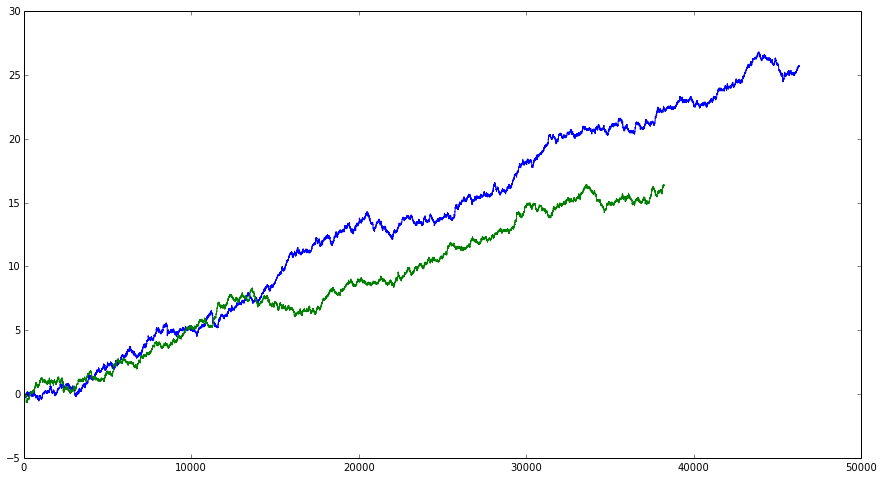

In [161]:
# look for trades where the prediction price is very far away from today's price
longPlots = []
shortPlots = []
longTotal = 0
shortTotal = 0
for i in range(0,len(dataArray),100):
    BL=0
    BS=0
    num = len(dataArray) - i
    if (num >100):
        num = 100
    #find best Delta for longs out of 100
    for l in range(num):
        long = dataArray[i+l][2] - dataArray[i+l][0]
        if(long>BL):
            BL = l
        
    # find best Delta for shorts out of 100
    for s in range(num):
        short = dataArray[i+s][0] - dataArray[i+s][2]
        if(short>BS):
            BS = s
    
    #store to arrays
    longTotal+=(dataArray[i+BL][1]-dataArray[i+BL][0])/dataArray[i+BL][1]
    longPlots.append(longTotal)

    shortTotal+=(dataArray[i+BS][0]-dataArray[i+BS][1])/dataArray[i+BS][1]
    shortPlots.append(shortTotal)
  

#  I don't know why this is red... 
# look for all trades, regardleses of how far the predicted price is from today's price
allLongPlots = []
allShortPlots = []
deltas = []
allShortPlotsTotal = 0
allLongPlotsTotal = 0
for i in range(len(dataArray)):
    long = dataArray[i][2] - dataArray[i][0]
    if(long>0):
        allLongPlotsTotal += (dataArray[i][1] - dataArray[i][0])/dataArray[i][1]
        allLongPlots.append(allLongPlotsTotal)
    if(long<0):
        allShortPlotsTotal += (dataArray[i][0] - dataArray[i][1])/dataArray[i][0]
        allShortPlots.append(allShortPlotsTotal)

    

#plot out just the 'big prediction delta' trades
# plt.rcParams['figure.figsize'] = (15, 8)
# fig1 = plt.figure()
# ax1 = fig1.add_subplot(111)
# ax1.plot(longPlots)  # blue
# ax1.plot(shortPlots)  # green

#plot out all trades
plt.rcParams['figure.figsize'] = (15, 8)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(allLongPlots)  # blue
ax2.plot(allShortPlots) # green


def printReturns(totalsArray, name):
    dayAvg = totalsArray[len(totalsArray) - 1]/len(totalsArray)
    yearAvg = dayAvg*250
    investment = (5000 + 5000*yearAvg)#*(1 - 500*(.03/50))
    wComsReturn = investment - (250*2)
    wSlipReturn = investment - (250*2) - (500*(100*.03))
    print('annual {} initial return: ${:.2f}, {:.4f}%'.format(name, investment, (investment/5000 - 1)*100))
    print('annual {} w/commision return: ${:.2f}, {:.4f}%'.format(name, wComsReturn, (wComsReturn/5000 - 1)*100))
    print('annual {} slippage return: ${:.2f}, {:.4f}%'.format(name, wSlipReturn, (wSlipReturn/5000 - 1)*100))
    print('')
    

# print('average prediction delta: {:.2f}'.format(np.mean(deltaArray)))

print('$5000 initial investment...')    
printReturns(allLongPlots[20000:],'longs')
printReturns(allShortPlots[20000:],'shorts')